In [1]:
## if you want to train the model
# ## # ## # ## # ## # ## # ## # ## # ## # ## # ## # ##

# ## STEP 0
# ## make sure you are in /models/research directory

# ## STEP 1
# ## create .record file by using YAML file using the following 
# ## python convert_to_TFRecord.py --input_path training_data/sim_training_data/sim_data_annotations.yaml --input_height 600 --input_width 800 --output_path training_data/sim_training_data/sim.record

# ## STEP 2
# ## edit config file of your network
# ## changes I made:
# ## 1- number of detections
# ## 2- num steps
# ## 3- random black patch and random contrast augmentation methods

# ## STEP 3
# ## train the model
# python object_detection/train.py --pipeline_config_path=ssd_mobilenet_v1_coco.config --train_dir=training_data/sim_training_data/sim_data_capture
          
# ## STEP 4
# ## save the model for inference
# python object_detection/export_inference_graph.py --pipeline_config_path=ssd_mobilenet_v1_coco.config --trained_checkpoint_prefix=training_data/sim_training_data/sim_data_capture/model.ckpt-3000 --output_directory=sim_frozen/

In [2]:
import numpy as np
import os
import sys
import tensorflow as tf
import time
from glob import glob

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
model = 'sim_frozen/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training_data/sim_training_data/sim_label_map.pbtxt'
NUM_CLASSES = 4

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'NoLight'}}


In [4]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## create an empty graph and load the model
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [5]:
PATH_TO_TEST_IMAGES_DIR = 'testing_data/sim_testing_data/'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images -- for plotting only
IMAGE_SIZE = (12, 8)

testing_data/sim_testing_data/*.jpg
Length of test images: 12


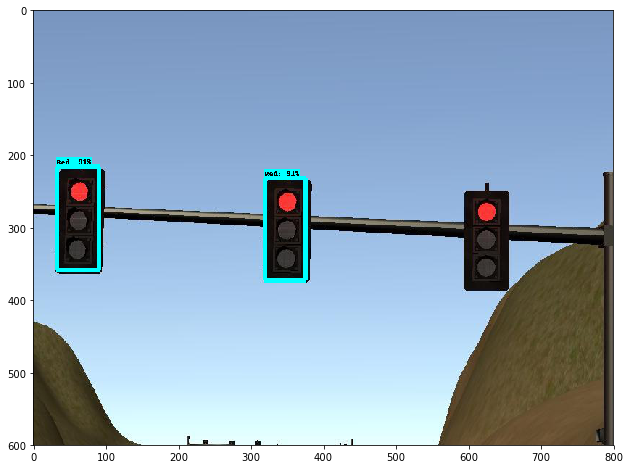

Red 0.919669
Distance (metres) 0.0
Time in milliseconds 1272.0592021942139 

Red 0.915197
Distance (metres) 0.0
Time in milliseconds 1272.0592021942139 



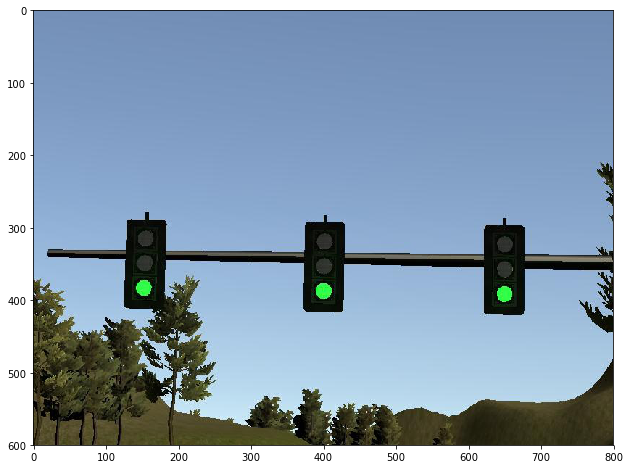

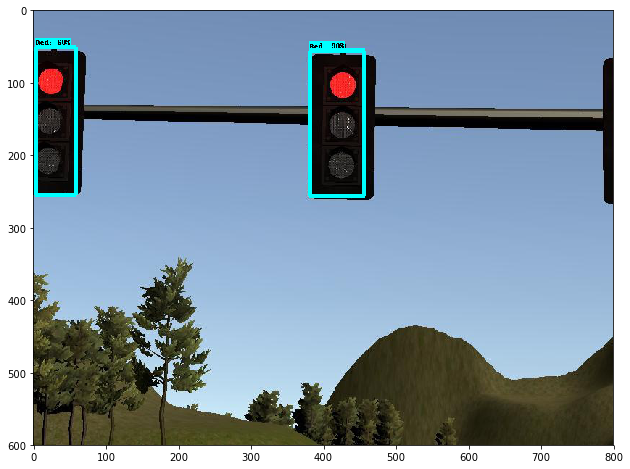

Red 0.983999
Distance (metres) 0.0
Time in milliseconds 17.316579818725586 

Red 0.60435
Distance (metres) 0.0
Time in milliseconds 17.316579818725586 



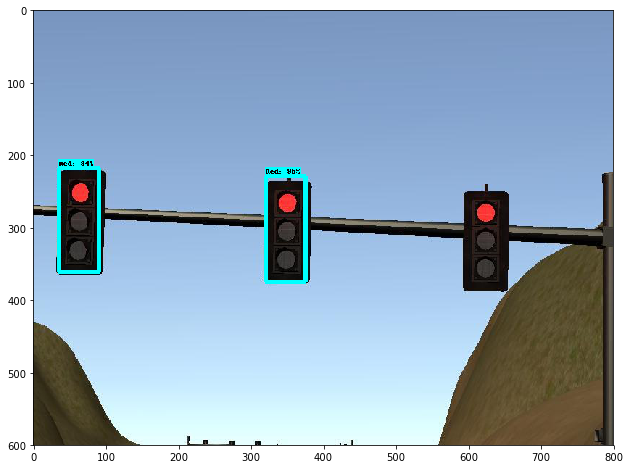

Red 0.95713
Distance (metres) 0.0
Time in milliseconds 16.88694953918457 

Red 0.947288
Distance (metres) 0.0
Time in milliseconds 16.88694953918457 



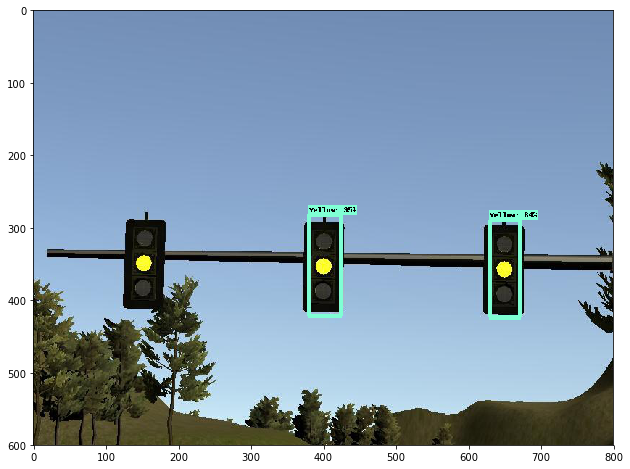

Yellow 0.954337
Distance (metres) 0.0
Time in milliseconds 17.312288284301758 

Yellow 0.845874
Distance (metres) 0.0
Time in milliseconds 17.312288284301758 



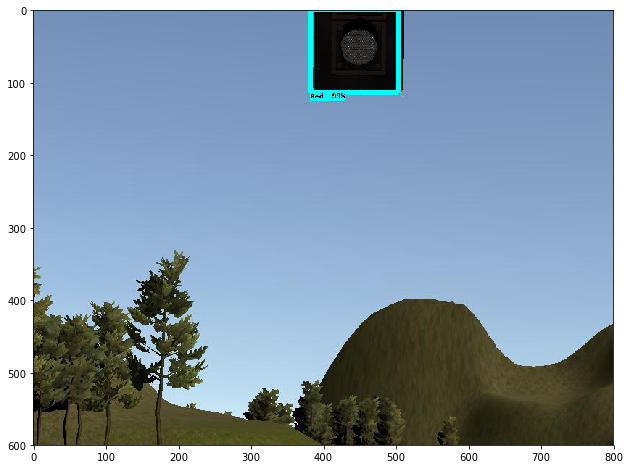

Red 0.996727
Distance (metres) 0.0
Time in milliseconds 16.855955123901367 



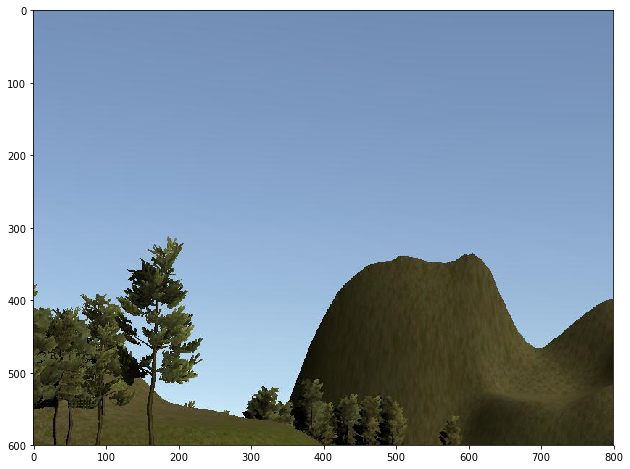

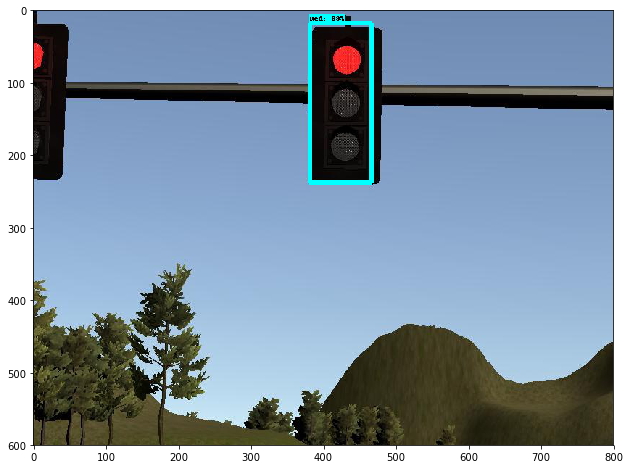

Red 0.996894
Distance (metres) 0.0
Time in milliseconds 17.2421932220459 



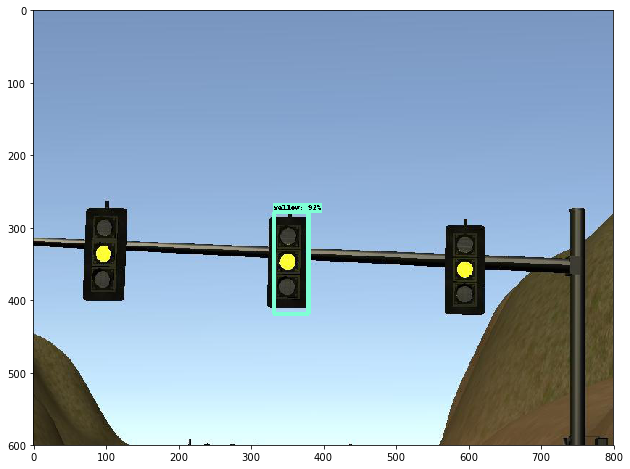

Yellow 0.922667
Distance (metres) 0.0
Time in milliseconds 17.10987091064453 



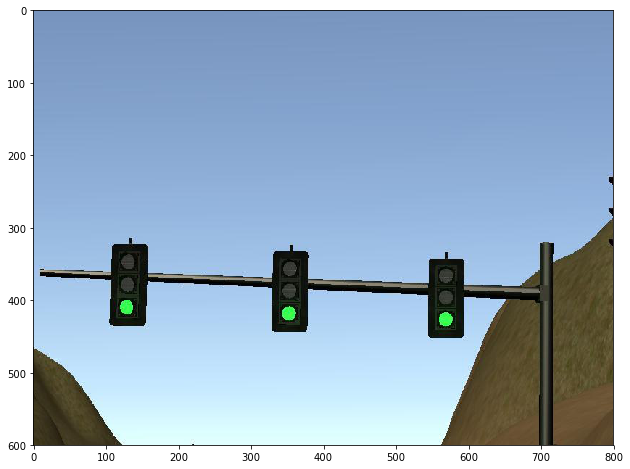

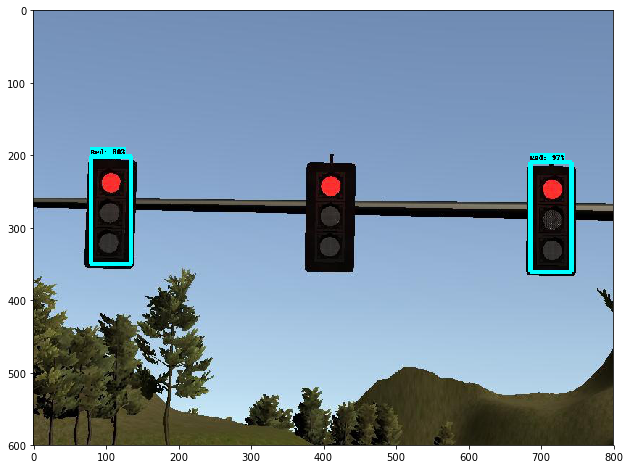

Red 0.975086
Distance (metres) 0.0
Time in milliseconds 17.04716682434082 

Red 0.807967
Distance (metres) 0.0
Time in milliseconds 17.04716682434082 



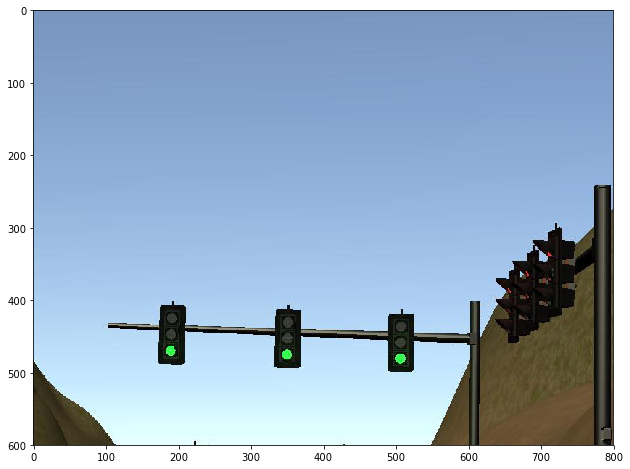

In [6]:
## detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")